In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from utils.matrix_builder import create_feature_matrix_with_features

def adaptive_learning_pipeline(df, lag_price_window, training_window_size, 
                             initial_train_size, step_size=1, alpha=0.1):
    """
    Implements adaptive learning with sliding window approach.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Full dataset with Datetime and features
    lag_price_window : int
        Number of historical price points as features (lag window)
    training_window_size : int
        Number of samples to use for each model training (sliding window)
    initial_train_size : int
        Size of initial training set before starting predictions
    step_size : int
        How many samples to move forward between retraining
    alpha : float
        Lasso regularization parameter
        
    Returns:
    --------
    results : dict
        Dictionary containing predictions, actual values, metrics, etc.
    """
    
    # Create full feature matrix once
    X_full, y_full = create_feature_matrix_with_features(df, lag_price_window)
    
    # Initialize storage for results
    predictions = []
    actual_values = []
    model_performances = []
    training_indices = []
    
    # Start predictions after initial training period
    start_idx = initial_train_size
    
    print(f"Starting adaptive learning:")
    print(f"- Total samples available: {len(X_full)}")
    print(f"- Training window size: {training_window_size}")
    print(f"- Initial training size: {initial_train_size}")
    print(f"- Starting predictions from index: {start_idx}")
    
    # Adaptive learning loop
    for i in range(start_idx, len(X_full), step_size):
        
        # Define training window (sliding window of most recent data)
        train_end_idx = i
        train_start_idx = max(0, train_end_idx - training_window_size)
        
        # Extract training data for this window
        X_train = X_full.iloc[train_start_idx:train_end_idx]
        y_train = y_full.iloc[train_start_idx:train_end_idx]
        
        # Train model on current window
        model = Lasso(alpha=alpha)
        model.fit(X_train, y_train)
        
        # Make prediction for next point(s)
        pred_end_idx = min(i + step_size, len(X_full))
        X_pred = X_full.iloc[i:pred_end_idx]
        y_actual = y_full.iloc[i:pred_end_idx]
        
        y_pred = model.predict(X_pred)
        
        # Store results
        predictions.extend(y_pred)
        actual_values.extend(y_actual.values)
        training_indices.append((train_start_idx, train_end_idx))
        
        # Calculate performance on training window (optional)
        train_pred = model.predict(X_train)
        train_mse = mean_squared_error(y_train, train_pred)
        model_performances.append(train_mse)
        
        if (i - start_idx) % 50 == 0:  # Progress update
            print(f"Processed {i - start_idx + step_size} predictions...")
    
    # Calculate overall performance
    predictions = np.array(predictions)
    actual_values = np.array(actual_values)
    
    overall_mse = mean_squared_error(actual_values, predictions)
    overall_mae = mean_absolute_error(actual_values, predictions)
    overall_r2 = r2_score(actual_values, predictions)
    
    results = {
        'predictions': predictions,
        'actual_values': actual_values,
        'model_performances': model_performances,
        'training_indices': training_indices,
        'overall_mse': overall_mse,
        'overall_mae': overall_mae,
        'overall_r2': overall_r2,
        'n_models_trained': len(model_performances)
    }
    
    return results

# Load and prepare your data
csv_hour_file = '../data/ta_metrics/new_price_metrics_hour_14.csv'
df = pd.read_csv(csv_hour_file, parse_dates=['Datetime'])

# Feature engineering
lag_price_window = 3
feature_columns = df.columns[1:]
df = df[['Datetime'] + list(feature_columns)]
df['day_of_week'] = df['Datetime'].dt.dayofweek
df['month'] = df['Datetime'].dt.month
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

# Filter date range
train_start_date = '2018-12-25'
train_end_date = '2019-02-01'
train_subset_df = df[(df['Datetime'] >= train_start_date) & (df['Datetime'] <= train_end_date)]

# Adaptive learning parameters
training_window_size = 100  # Number of samples per training window
initial_train_size = 150    # Initial training before starting predictions
step_size = 1              # Retrain every N samples (1 = every sample)

# Run adaptive learning
results = adaptive_learning_pipeline(
    df=train_subset_df,
    lag_price_window=lag_price_window,
    training_window_size=training_window_size,
    initial_train_size=initial_train_size,
    step_size=step_size,
    alpha=0.1
)

# Print results
print(f"\nAdaptive Learning Results:")
print(f"Total predictions made: {len(results['predictions'])}")
print(f"Models trained: {results['n_models_trained']}")
print(f"Overall MSE: {results['overall_mse']:.4f}")
print(f"Overall MAE: {results['overall_mae']:.4f}")
print(f"Overall R²: {results['overall_r2']:.4f}")

# Optional: Compare with static approach
print(f"\nComparing with static training...")
X_static, y_static = create_feature_matrix_with_features(train_subset_df, lag_price_window)
split_point = int(len(X_static) * 0.5)
X_train_static = X_static.iloc[:split_point]
X_test_static = X_static.iloc[split_point:]
y_train_static = y_static.iloc[:split_point]
y_test_static = y_static.iloc[split_point:]

lasso_static = Lasso(alpha=0.1)
lasso_static.fit(X_train_static, y_train_static)
y_pred_static = lasso_static.predict(X_test_static)

static_mse = mean_squared_error(y_test_static, y_pred_static)
static_mae = mean_absolute_error(y_test_static, y_pred_static)
static_r2 = r2_score(y_test_static, y_pred_static)

print(f"Static MSE: {static_mse:.4f}")
print(f"Static MAE: {static_mae:.4f}")
print(f"Static R²: {static_r2:.4f}")

print(f"\nImprovement with adaptive learning:")
print(f"MSE improvement: {((static_mse - results['overall_mse']) / static_mse * 100):.2f}%")
print(f"MAE improvement: {((static_mae - results['overall_mae']) / static_mae * 100):.2f}%")

Starting adaptive learning:
- Total samples available: 35
- Training window size: 100
- Initial training size: 150
- Starting predictions from index: 150


ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.

In [9]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from utils.matrix_builder import create_feature_matrix_with_features

def adaptive_learning_pipeline(df, lag_price_window, training_window_size, 
                             initial_train_size, step_size=1, alpha=0.1):
    """
    Implements adaptive learning with sliding window approach.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Full dataset with Datetime and features
    lag_price_window : int
        Number of historical price points as features (lag window)
    training_window_size : int
        Number of samples to use for each model training (sliding window)
    initial_train_size : int
        Size of initial training set before starting predictions
    step_size : int
        How many samples to move forward between retraining
    alpha : float
        Lasso regularization parameter
        
    Returns:
    --------
    results : dict
        Dictionary containing predictions, actual values, metrics, etc.
    """
    
    # Create full feature matrix once
    X_full, y_full = create_feature_matrix_with_features(df, lag_price_window)
    
    # Validate parameters against available data
    total_samples = len(X_full)
    if total_samples == 0:
        raise ValueError("No samples available after creating feature matrix")
    
    # Adjust parameters if they're too large for the dataset
    min_train_size = max(5, total_samples // 4)  # At least 5 samples or 25% of data
    max_initial_size = total_samples - 2  # Leave at least 2 samples for prediction
    
    adjusted_initial_train_size = min(initial_train_size, max_initial_size)
    adjusted_training_window_size = min(training_window_size, adjusted_initial_train_size)
    
    if adjusted_initial_train_size < min_train_size:
        raise ValueError(f"Dataset too small. Need at least {min_train_size + 2} samples after feature creation, but got {total_samples}")
    
    # Initialize storage for results
    predictions = []
    actual_values = []
    model_performances = []
    training_indices = []
    
    # Start predictions after initial training period
    start_idx = adjusted_initial_train_size
    
    print(f"Starting adaptive learning:")
    print(f"- Total samples available: {total_samples}")
    print(f"- Training window size: {adjusted_training_window_size} (adjusted from {training_window_size})")
    print(f"- Initial training size: {adjusted_initial_train_size} (adjusted from {initial_train_size})")
    print(f"- Starting predictions from index: {start_idx}")
    print(f"- Samples available for prediction: {total_samples - start_idx}")
    
    if total_samples - start_idx <= 0:
        print("Warning: No samples available for prediction with current parameters")
        return {
            'predictions': np.array([]),
            'actual_values': np.array([]),
            'model_performances': [],
            'training_indices': [],
            'overall_mse': np.nan,
            'overall_mae': np.nan,
            'overall_r2': np.nan,
            'n_models_trained': 0
        }
    
    # Adaptive learning loop
    for i in range(start_idx, total_samples, step_size):
        
        # Define training window (sliding window of most recent data)
        train_end_idx = i
        train_start_idx = max(0, train_end_idx - adjusted_training_window_size)
        
        # Extract training data for this window
        X_train = X_full.iloc[train_start_idx:train_end_idx]
        y_train = y_full.iloc[train_start_idx:train_end_idx]
        
        # Skip if training set is too small
        if len(X_train) < 2:
            continue
        
        # Train model on current window
        model = Lasso(alpha=alpha)
        model.fit(X_train, y_train)
        
        # Make prediction for next point(s)
        pred_end_idx = min(i + step_size, total_samples)
        X_pred = X_full.iloc[i:pred_end_idx]
        y_actual = y_full.iloc[i:pred_end_idx]
        
        y_pred = model.predict(X_pred)
        
        # Store results
        predictions.extend(y_pred)
        actual_values.extend(y_actual.values)
        training_indices.append((train_start_idx, train_end_idx))
        
        # Calculate performance on training window (optional)
        train_pred = model.predict(X_train)
        train_mse = mean_squared_error(y_train, train_pred)
        model_performances.append(train_mse)
        
        if (i - start_idx) % 10 == 0:  # More frequent progress updates for small datasets
            print(f"Processed {i - start_idx + step_size} predictions...")
    
    # Calculate overall performance only if we have predictions
    if len(predictions) == 0:
        print("No predictions were made!")
        return {
            'predictions': np.array([]),
            'actual_values': np.array([]),
            'model_performances': [],
            'training_indices': [],
            'overall_mse': np.nan,
            'overall_mae': np.nan,
            'overall_r2': np.nan,
            'n_models_trained': 0
        }
    
    predictions = np.array(predictions)
    actual_values = np.array(actual_values)
    
    overall_mse = mean_squared_error(actual_values, predictions)
    overall_mae = mean_absolute_error(actual_values, predictions)
    overall_r2 = r2_score(actual_values, predictions)
    
    results = {
        'predictions': predictions,
        'actual_values': actual_values,
        'model_performances': model_performances,
        'training_indices': training_indices,
        'overall_mse': overall_mse,
        'overall_mae': overall_mae,
        'overall_r2': overall_r2,
        'n_models_trained': len(model_performances)
    }
    
    return results

# Load and prepare your data
csv_hour_file = '../data/ta_metrics/new_price_metrics_hour_14.csv'
df = pd.read_csv(csv_hour_file, parse_dates=['Datetime'])

# Feature engineering
lag_price_window = 3
feature_columns = df.columns[1:]
df = df[['Datetime'] + list(feature_columns)]
df['day_of_week'] = df['Datetime'].dt.dayofweek
df['month'] = df['Datetime'].dt.month
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

# Filter date range
train_start_date = '2018-12-25'
train_end_date = '2019-02-01'
train_subset_df = df[(df['Datetime'] >= train_start_date) & (df['Datetime'] <= train_end_date)]

# Adaptive learning parameters - adjusted for small dataset
training_window_size = 15   # Reduced from 100
initial_train_size = 20     # Reduced from 150  
step_size = 1              # Retrain every N samples (1 = every sample)

# Run adaptive learning
results = adaptive_learning_pipeline(
    df=train_subset_df,
    lag_price_window=lag_price_window,
    training_window_size=training_window_size,
    initial_train_size=initial_train_size,
    step_size=step_size,
    alpha=0.1
)

# Print results
print(f"\nAdaptive Learning Results:")
print(f"Total predictions made: {len(results['predictions'])}")
print(f"Models trained: {results['n_models_trained']}")
print(f"Overall MSE: {results['overall_mse']:.4f}")
print(f"Overall MAE: {results['overall_mae']:.4f}")
print(f"Overall R²: {results['overall_r2']:.4f}")

# Optional: Compare with static approach
print(f"\nComparing with static training...")
X_static, y_static = create_feature_matrix_with_features(train_subset_df, lag_price_window)
split_point = int(len(X_static) * 0.5)
X_train_static = X_static.iloc[:split_point]
X_test_static = X_static.iloc[split_point:]
y_train_static = y_static.iloc[:split_point]
y_test_static = y_static.iloc[split_point:]

lasso_static = Lasso(alpha=0.1)
lasso_static.fit(X_train_static, y_train_static)
y_pred_static = lasso_static.predict(X_test_static)

static_mse = mean_squared_error(y_test_static, y_pred_static)
static_mae = mean_absolute_error(y_test_static, y_pred_static)
static_r2 = r2_score(y_test_static, y_pred_static)

print(f"Static MSE: {static_mse:.4f}")
print(f"Static MAE: {static_mae:.4f}")
print(f"Static R²: {static_r2:.4f}")

print(f"\nImprovement with adaptive learning:")
print(f"MSE improvement: {((static_mse - results['overall_mse']) / static_mse * 100):.2f}%")
print(f"MAE improvement: {((static_mae - results['overall_mae']) / static_mae * 100):.2f}%")

Starting adaptive learning:
- Total samples available: 35
- Training window size: 15 (adjusted from 15)
- Initial training size: 20 (adjusted from 20)
- Starting predictions from index: 20
- Samples available for prediction: 15
Processed 1 predictions...
Processed 11 predictions...

Adaptive Learning Results:
Total predictions made: 15
Models trained: 15
Overall MSE: 117.6764
Overall MAE: 6.9400
Overall R²: -1.9132

Comparing with static training...
Static MSE: 91.7545
Static MAE: 5.5417
Static R²: -1.3928

Improvement with adaptive learning:
MSE improvement: -28.25%
MAE improvement: -25.23%


/Users/rodrigodelama/Library/Mobile Documents/com~apple~CloudDocs/uc3m/TFG/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.743e+00, tolerance: 6.711e-02
  model = cd_fast.enet_coordinate_descent(
/Users/rodrigodelama/Library/Mobile Documents/com~apple~CloudDocs/uc3m/TFG/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.159e+01, tolerance: 6.688e-02
  model = cd_fast.enet_coordinate_descent(
/Users/rodrigodelama/Library/Mobile Documents/com~apple~CloudDocs/uc3m/TFG/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: Con

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from utils.matrix_builder import create_feature_matrix_with_features

def adaptive_learning_pipeline(df, lag_price_window, training_window_size, 
                             initial_train_size, step_size=1, alpha=0.1):
    """
    Implements adaptive learning with sliding window approach.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Full dataset with Datetime and features
    lag_price_window : int
        Number of historical price points as features (lag window)
    training_window_size : int
        Number of samples to use for each model training (sliding window)
    initial_train_size : int
        Size of initial training set before starting predictions
    step_size : int
        How many samples to move forward between retraining
    alpha : float
        Lasso regularization parameter
        
    Returns:
    --------
    results : dict
        Dictionary containing predictions, actual values, metrics, etc.
    """
    
    # Create full feature matrix once
    X_full, y_full = create_feature_matrix_with_features(df, lag_price_window)
    
    # Validate parameters against available data
    total_samples = len(X_full)
    if total_samples == 0:
        raise ValueError("No samples available after creating feature matrix")
    
    # Adjust parameters if they're too large for the dataset
    min_train_size = max(5, 20)  # At least 20 samples for meaningful training
    max_initial_size = total_samples - 10  # Leave at least 10 samples for prediction
    
    # Adjust initial training size if too large
    if initial_train_size > max_initial_size:
        adjusted_initial_train_size = max_initial_size
        print(f"Warning: Adjusted initial_train_size from {initial_train_size} to {adjusted_initial_train_size}")
    else:
        adjusted_initial_train_size = initial_train_size
    
    # Adjust training window size if too large
    if training_window_size > adjusted_initial_train_size:
        adjusted_training_window_size = adjusted_initial_train_size
        print(f"Warning: Adjusted training_window_size from {training_window_size} to {adjusted_training_window_size}")
    else:
        adjusted_training_window_size = training_window_size
    
    # Final validation
    if adjusted_initial_train_size < min_train_size:
        raise ValueError(f"Dataset too small. Need at least {min_train_size + 10} samples after feature creation, but got {total_samples}")
    
    if total_samples - adjusted_initial_train_size < 1:
        raise ValueError(f"No samples left for prediction. Need more data or smaller initial_train_size.")
    
    # Initialize storage for results
    predictions = []
    actual_values = []
    model_performances = []
    training_indices = []
    
    # Start predictions after initial training period
    start_idx = adjusted_initial_train_size
    
    print(f"Starting adaptive learning:")
    print(f"- Total samples available: {total_samples}")
    print(f"- Training window size: {adjusted_training_window_size}")
    print(f"- Initial training size: {adjusted_initial_train_size}")
    print(f"- Starting predictions from index: {start_idx}")
    print(f"- Samples available for prediction: {total_samples - start_idx}")
    print(f"- Expected number of models to train: {total_samples - start_idx}")
    
    if total_samples - start_idx <= 0:
        print("Warning: No samples available for prediction with current parameters")
        return {
            'predictions': np.array([]),
            'actual_values': np.array([]),
            'model_performances': [],
            'training_indices': [],
            'overall_mse': np.nan,
            'overall_mae': np.nan,
            'overall_r2': np.nan,
            'n_models_trained': 0
        }
    
    # Adaptive learning loop
    for i in range(start_idx, total_samples, step_size):
        
        # Define training window (sliding window of most recent data)
        train_end_idx = i
        train_start_idx = max(0, train_end_idx - adjusted_training_window_size)
        
        # Extract training data for this window
        X_train = X_full.iloc[train_start_idx:train_end_idx]
        y_train = y_full.iloc[train_start_idx:train_end_idx]
        
        # Skip if training set is too small
        if len(X_train) < 2:
            continue
        
        # Train model on current window
        model = Lasso(alpha=alpha)
        model.fit(X_train, y_train)
        
        # Make prediction for next point(s)
        pred_end_idx = min(i + step_size, total_samples)
        X_pred = X_full.iloc[i:pred_end_idx]
        y_actual = y_full.iloc[i:pred_end_idx]
        
        y_pred = model.predict(X_pred)
        
        # Store results
        predictions.extend(y_pred)
        actual_values.extend(y_actual.values)
        training_indices.append((train_start_idx, train_end_idx))
        
        # Calculate performance on training window (optional)
        train_pred = model.predict(X_train)
        train_mse = mean_squared_error(y_train, train_pred)
        model_performances.append(train_mse)
        
        if (i - start_idx) % 10 == 0:  # More frequent progress updates for small datasets
            print(f"Processed {i - start_idx + step_size} predictions...")
    
    # Calculate overall performance only if we have predictions
    if len(predictions) == 0:
        print("No predictions were made!")
        return {
            'predictions': np.array([]),
            'actual_values': np.array([]),
            'model_performances': [],
            'training_indices': [],
            'overall_mse': np.nan,
            'overall_mae': np.nan,
            'overall_r2': np.nan,
            'n_models_trained': 0
        }
    
    predictions = np.array(predictions)
    actual_values = np.array(actual_values)
    
    overall_mse = mean_squared_error(actual_values, predictions)
    overall_mae = mean_absolute_error(actual_values, predictions)
    overall_r2 = r2_score(actual_values, predictions)
    
    results = {
        'predictions': predictions,
        'actual_values': actual_values,
        'model_performances': model_performances,
        'training_indices': training_indices,
        'overall_mse': overall_mse,
        'overall_mae': overall_mae,
        'overall_r2': overall_r2,
        'n_models_trained': len(model_performances)
    }
    
    return results

# Load and prepare your data
csv_hour_file = '../data/ta_metrics/new_price_metrics_hour_14.csv'
df = pd.read_csv(csv_hour_file, parse_dates=['Datetime'])

# Feature engineering
lag_price_window = 3
feature_columns = df.columns[1:]
df = df[['Datetime'] + list(feature_columns)]
df['day_of_week'] = df['Datetime'].dt.dayofweek
df['month'] = df['Datetime'].dt.month
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

# Filter date range
train_start_date = '2018-12-01'
train_end_date = '2025-03-01'
train_subset_df = df[(df['Datetime'] >= train_start_date) & (df['Datetime'] <= train_end_date)]

# Adaptive learning parameters - reasonable for larger dataset
training_window_size = 100  # Number of samples per training window
initial_train_size = 200    # Initial training before starting predictions
step_size = 1              # Retrain every N samples (1 = every sample)

# Run adaptive learning
results = adaptive_learning_pipeline(
    df=train_subset_df,
    lag_price_window=lag_price_window,
    training_window_size=training_window_size,
    initial_train_size=initial_train_size,
    step_size=step_size,
    alpha=0.1
)

# Print results
print(f"\nAdaptive Learning Results:")
print(f"Total predictions made: {len(results['predictions'])}")
print(f"Models trained: {results['n_models_trained']}")
print(f"Overall MSE: {results['overall_mse']:.4f}")
print(f"Overall MAE: {results['overall_mae']:.4f}")
print(f"Overall R²: {results['overall_r2']:.4f}")

# Optional: Compare with static approach
print(f"\nComparing with static training...")
X_static, y_static = create_feature_matrix_with_features(train_subset_df, lag_price_window)
split_point = int(len(X_static) * 0.5)
X_train_static = X_static.iloc[:split_point]
X_test_static = X_static.iloc[split_point:]
y_train_static = y_static.iloc[:split_point]
y_test_static = y_static.iloc[split_point:]

lasso_static = Lasso(alpha=0.1)
lasso_static.fit(X_train_static, y_train_static)
y_pred_static = lasso_static.predict(X_test_static)

static_mse = mean_squared_error(y_test_static, y_pred_static)
static_mae = mean_absolute_error(y_test_static, y_pred_static)
static_r2 = r2_score(y_test_static, y_pred_static)

print(f"Static MSE: {static_mse:.4f}")
print(f"Static MAE: {static_mae:.4f}")
print(f"Static R²: {static_r2:.4f}")

print(f"\nImprovement with adaptive learning:")
print(f"MSE improvement: {((static_mse - results['overall_mse']) / static_mse * 100):.2f}%")
print(f"MAE improvement: {((static_mae - results['overall_mae']) / static_mae * 100):.2f}%")

Plot saved as adaptive_comprehensive_analysis.png


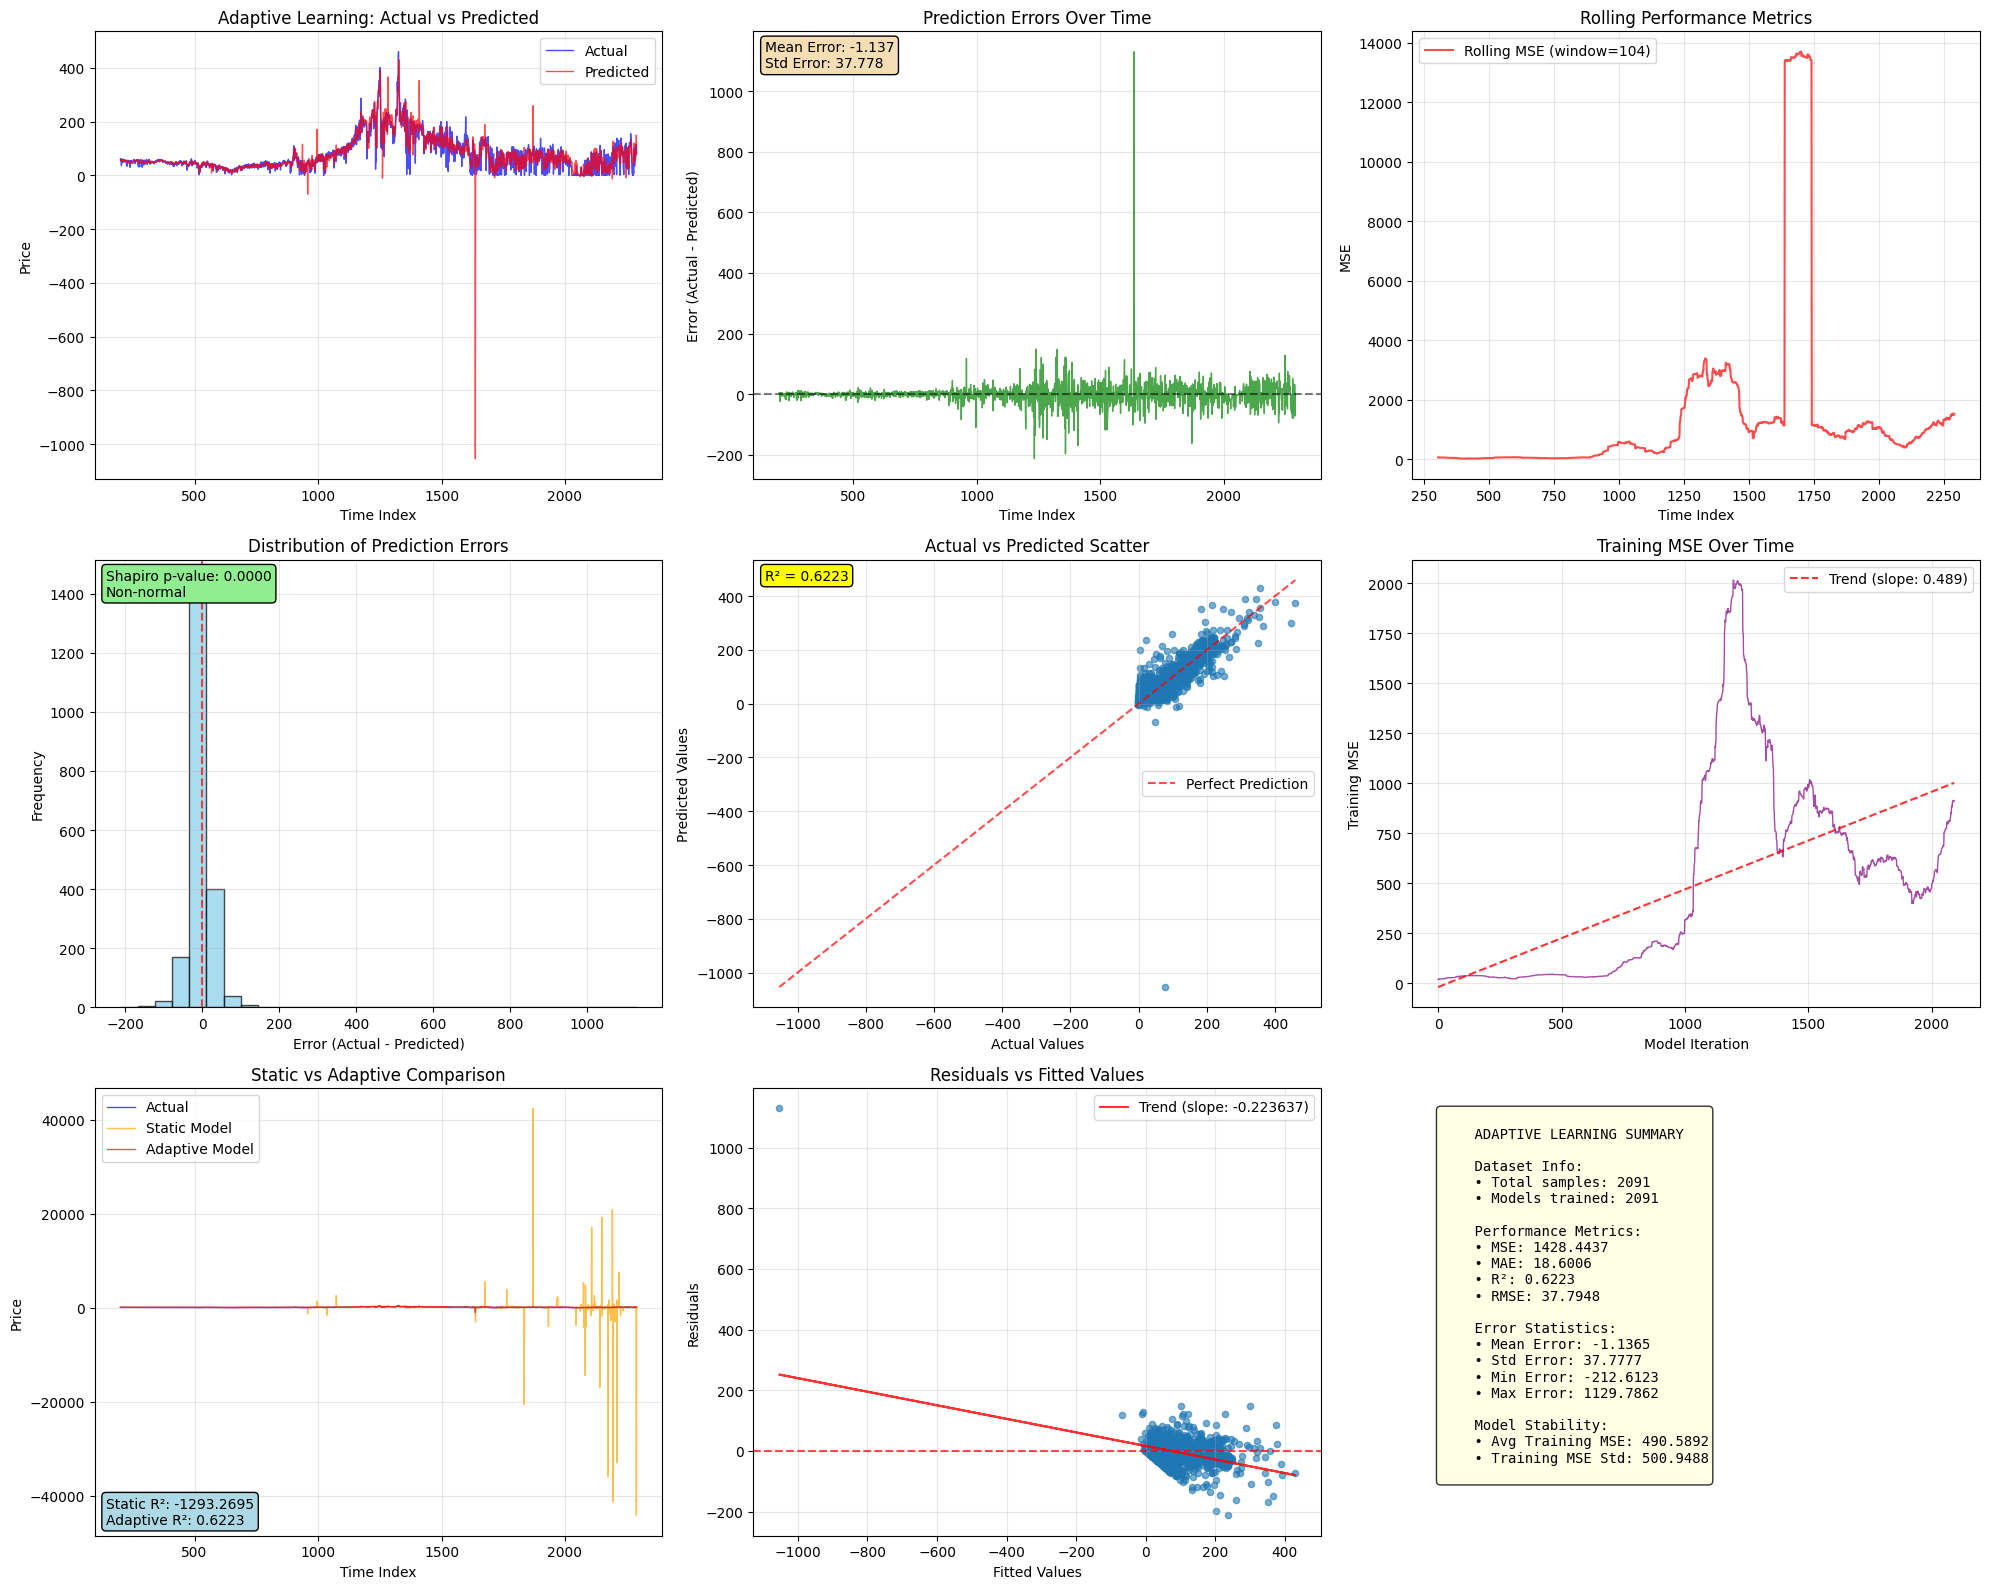


ADAPTIVE LEARNING VALIDATION ANALYSIS

1. PERFORMANCE METRICS:
   MSE: 1428.4437
   MAE: 18.6006
   R²:  0.6223
   RMSE: 37.7948

2. ERROR ANALYSIS:
   Mean Error: -1.1365 (should be close to 0)
   Error Std:  37.7777
   Error Range: [-212.61, 1129.79]

3. MODEL STABILITY:
   Models Trained: 2091
   Avg Training MSE: 490.5892
   Training MSE Variation: 500.9488

4. VALIDATION CHECKS:
   Error Trend: -0.000401 (should be close to 0)
   Residual Pattern: Good
   ✅ No significant systematic bias detected
   ✅ R² indicates reasonable model performance


In [34]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings

def plot_adaptive_learning_results(results, train_subset_df, lag_price_window, 
                                 static_comparison=True, save_plots=False, plot_prefix="adaptive"):
    """
    Create comprehensive plots to validate adaptive learning results.
    
    Parameters:
    -----------
    results : dict
        Results from adaptive_learning_pipeline
    train_subset_df : pandas.DataFrame
        Original training dataset
    lag_price_window : int
        Price feature window used
    static_comparison : bool
        Whether to include static model comparison
    save_plots : bool
        Whether to save plots as files
    plot_prefix : str
        Prefix for saved plot filenames
    """
    
    # Create figure with subplots
    fig = plt.figure(figsize=(20, 16))
    
    # 1. Actual vs Predicted Time Series
    ax1 = plt.subplot(3, 3, 1)
    predictions = results['predictions']
    actual_values = results['actual_values']
    
    # Create time index for predictions (offset by initial training + price window)
    start_idx = len(train_subset_df) - len(predictions) - lag_price_window
    time_range = range(start_idx, start_idx + len(predictions))
    
    plt.plot(time_range, actual_values, 'b-', label='Actual', alpha=0.7, linewidth=1)
    plt.plot(time_range, predictions, 'r-', label='Predicted', alpha=0.7, linewidth=1)
    plt.title('Adaptive Learning: Actual vs Predicted')
    plt.xlabel('Time Index')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 2. Prediction Errors Over Time
    ax2 = plt.subplot(3, 3, 2)
    errors = actual_values - predictions
    plt.plot(time_range, errors, 'g-', alpha=0.7, linewidth=1)
    plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    plt.title('Prediction Errors Over Time')
    plt.xlabel('Time Index')
    plt.ylabel('Error (Actual - Predicted)')
    plt.grid(True, alpha=0.3)
    
    # Add error statistics
    plt.text(0.02, 0.98, f'Mean Error: {np.mean(errors):.3f}\nStd Error: {np.std(errors):.3f}', 
             transform=ax2.transAxes, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat'))
    
    # 3. Rolling Performance Metrics
    ax3 = plt.subplot(3, 3, 3)
    window_size = max(10, len(predictions) // 20)  # Adaptive window size
    rolling_mse = []
    rolling_mae = []
    rolling_r2 = []
    
    for i in range(window_size, len(predictions)):
        window_actual = actual_values[i-window_size:i]
        window_pred = predictions[i-window_size:i]
        
        rolling_mse.append(mean_squared_error(window_actual, window_pred))
        rolling_mae.append(mean_absolute_error(window_actual, window_pred))
        rolling_r2.append(r2_score(window_actual, window_pred))
    
    rolling_time = time_range[window_size:]
    plt.plot(rolling_time, rolling_mse, 'r-', label=f'Rolling MSE (window={window_size})', alpha=0.7)
    plt.title('Rolling Performance Metrics')
    plt.xlabel('Time Index')
    plt.ylabel('MSE')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 4. Error Distribution
    ax4 = plt.subplot(3, 3, 4)
    plt.hist(errors, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    plt.axvline(x=0, color='red', linestyle='--', alpha=0.7)
    plt.title('Distribution of Prediction Errors')
    plt.xlabel('Error (Actual - Predicted)')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)
    
    # Add normality info
    from scipy import stats
    _, p_value = stats.shapiro(errors[:min(5000, len(errors))])  # Shapiro-Wilk test (max 5000 samples)
    plt.text(0.02, 0.98, f'Shapiro p-value: {p_value:.4f}\n{"Normal" if p_value > 0.05 else "Non-normal"}', 
             transform=ax4.transAxes, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightgreen'))
    
    # 5. Actual vs Predicted Scatter Plot
    ax5 = plt.subplot(3, 3, 5)
    plt.scatter(actual_values, predictions, alpha=0.6, s=20)
    
    # Perfect prediction line
    min_val = min(min(actual_values), min(predictions))
    max_val = max(max(actual_values), max(predictions))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.7, label='Perfect Prediction')
    
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Actual vs Predicted Scatter')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Add R² to plot
    r2_adaptive = r2_score(actual_values, predictions)
    plt.text(0.02, 0.98, f'R² = {r2_adaptive:.4f}', transform=ax5.transAxes, 
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='yellow'))
    
    # 6. Model Training Performance Over Time
    ax6 = plt.subplot(3, 3, 6)
    if results['model_performances']:
        training_performance = results['model_performances']
        plt.plot(range(len(training_performance)), training_performance, 'purple', alpha=0.7, linewidth=1)
        plt.title('Training MSE Over Time')
        plt.xlabel('Model Iteration')
        plt.ylabel('Training MSE')
        plt.grid(True, alpha=0.3)
        
        # Add trend line
        z = np.polyfit(range(len(training_performance)), training_performance, 1)
        p = np.poly1d(z)
        plt.plot(range(len(training_performance)), p(range(len(training_performance))), 
                "r--", alpha=0.8, label=f'Trend (slope: {z[0]:.3f})')
        plt.legend()
    
    # 7. Static vs Adaptive Comparison (if available)
    if static_comparison:
        ax7 = plt.subplot(3, 3, 7)
        
        # Run static comparison
        from utils.matrix_builder import create_feature_matrix_with_features
        X_static, y_static = create_feature_matrix_with_features(train_subset_df, lag_price_window)
        
        # Use same split as adaptive (approximately)
        split_point = len(X_static) - len(predictions)
        X_train_static = X_static.iloc[:split_point]
        X_test_static = X_static.iloc[split_point:]
        y_train_static = y_static.iloc[:split_point]
        y_test_static = y_static.iloc[split_point:]
        
        # Train static model with better parameters to avoid convergence issues
        lasso_static = Lasso(alpha=0.1, max_iter=2000, tol=1e-4)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            lasso_static.fit(X_train_static, y_train_static)
        
        y_pred_static = lasso_static.predict(X_test_static)
        
        # Plot comparison
        comparison_time = time_range[:len(y_test_static)]
        plt.plot(comparison_time, y_test_static.values, 'b-', label='Actual', alpha=0.7, linewidth=1)
        plt.plot(comparison_time, y_pred_static, 'orange', label='Static Model', alpha=0.7, linewidth=1)
        plt.plot(comparison_time, predictions[:len(y_pred_static)], 'r-', label='Adaptive Model', alpha=0.7, linewidth=1)
        
        plt.title('Static vs Adaptive Comparison')
        plt.xlabel('Time Index')
        plt.ylabel('Price')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Performance comparison in text box
        static_r2 = r2_score(y_test_static, y_pred_static)
        adaptive_r2 = r2_score(y_test_static.values, predictions[:len(y_pred_static)])
        
        plt.text(0.02, 0.02, f'Static R²: {static_r2:.4f}\nAdaptive R²: {adaptive_r2:.4f}', 
                 transform=ax7.transAxes, verticalalignment='bottom', 
                 bbox=dict(boxstyle='round', facecolor='lightblue'))
    
    # 8. Residuals vs Fitted
    ax8 = plt.subplot(3, 3, 8)
    plt.scatter(predictions, errors, alpha=0.6, s=20)
    plt.axhline(y=0, color='red', linestyle='--', alpha=0.7)
    plt.xlabel('Fitted Values')
    plt.ylabel('Residuals')
    plt.title('Residuals vs Fitted Values')
    plt.grid(True, alpha=0.3)
    
    # Add trend line for residuals
    z = np.polyfit(predictions, errors, 1)
    p = np.poly1d(z)
    plt.plot(predictions, p(predictions), "r-", alpha=0.8, 
             label=f'Trend (slope: {z[0]:.6f})')
    plt.legend()
    
    # 9. Performance Summary
    ax9 = plt.subplot(3, 3, 9)
    ax9.axis('off')
    
    # Summary statistics
    summary_text = f"""
    ADAPTIVE LEARNING SUMMARY
    
    Dataset Info:
    • Total samples: {len(predictions)}
    • Models trained: {results['n_models_trained']}
    
    Performance Metrics:
    • MSE: {results['overall_mse']:.4f}
    • MAE: {results['overall_mae']:.4f}
    • R²: {results['overall_r2']:.4f}
    • RMSE: {np.sqrt(results['overall_mse']):.4f}
    
    Error Statistics:
    • Mean Error: {np.mean(errors):.4f}
    • Std Error: {np.std(errors):.4f}
    • Min Error: {np.min(errors):.4f}
    • Max Error: {np.max(errors):.4f}
    
    Model Stability:
    • Avg Training MSE: {np.mean(results['model_performances']):.4f}
    • Training MSE Std: {np.std(results['model_performances']):.4f}
    """
    
    ax9.text(0.05, 0.95, summary_text, transform=ax9.transAxes, fontsize=10,
             verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))
    
    plt.tight_layout()
    
    if save_plots:
        plt.savefig(f'{plot_prefix}_comprehensive_analysis.png', dpi=300, bbox_inches='tight')
        print(f"Plot saved as {plot_prefix}_comprehensive_analysis.png")
    
    plt.show()
    
    # Print detailed analysis
    print("\n" + "="*60)
    print("ADAPTIVE LEARNING VALIDATION ANALYSIS")
    print("="*60)
    
    print(f"\n1. PERFORMANCE METRICS:")
    print(f"   MSE: {results['overall_mse']:.4f}")
    print(f"   MAE: {results['overall_mae']:.4f}")
    print(f"   R²:  {results['overall_r2']:.4f}")
    print(f"   RMSE: {np.sqrt(results['overall_mse']):.4f}")
    
    print(f"\n2. ERROR ANALYSIS:")
    print(f"   Mean Error: {np.mean(errors):.4f} (should be close to 0)")
    print(f"   Error Std:  {np.std(errors):.4f}")
    print(f"   Error Range: [{np.min(errors):.2f}, {np.max(errors):.2f}]")
    
    print(f"\n3. MODEL STABILITY:")
    print(f"   Models Trained: {results['n_models_trained']}")
    print(f"   Avg Training MSE: {np.mean(results['model_performances']):.4f}")
    print(f"   Training MSE Variation: {np.std(results['model_performances']):.4f}")
    
    print(f"\n4. VALIDATION CHECKS:")
    error_trend = np.polyfit(range(len(errors)), errors, 1)[0]
    print(f"   Error Trend: {error_trend:.6f} (should be close to 0)")
    print(f"   Residual Pattern: {'Good' if abs(error_trend) < 0.001 else 'Check for bias'}")
    
    if abs(np.mean(errors)) > np.std(errors) * 0.1:
        print("   ⚠️  WARNING: Systematic bias detected in predictions")
    else:
        print("   ✅ No significant systematic bias detected")
    
    if results['overall_r2'] < 0:
        print("   ⚠️  WARNING: R² is negative - model performs worse than mean prediction")
    elif results['overall_r2'] < 0.3:
        print("   ⚠️  WARNING: Low R² suggests poor model fit")
    else:
        print("   ✅ R² indicates reasonable model performance")

# Usage example:
plot_adaptive_learning_results(results, train_subset_df, lag_price_window, 
                               static_comparison=True, save_plots=True)

In [ ]:
import pandas as pd
import numpy as np
import warnings
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from utils.matrix_builder import create_ta_feature_matrix

def adaptive_learning_pipeline(df, lag_price_window, training_window_size, 
                             initial_train_size, step_size=1, alpha=0.1):
    """
    Implements adaptive learning with sliding window approach.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Full dataset with Datetime and features
    lag_price_window : int
        Number of historical price points as features (lag window inside create_feature_matrix_with_features)
    training_window_size : int
        Number of samples to use for each model training (sliding window)
    initial_train_size : int
        Size of initial training set before starting predictions
    step_size : int
        How many samples to move forward between retraining
    alpha : float
        Lasso regularization parameter
        
    Returns:
    --------
    results : dict
        Dictionary containing predictions, actual values, metrics, etc.
    """
    
    # Create full feature matrix once
    X_full, y_full = create_ta_feature_matrix(df, lag_price_window)
    
    # Validate parameters against available data
    total_samples = len(X_full)
    if total_samples == 0:
        raise ValueError("No samples available after creating feature matrix")
    
    # Adjust parameters if they're too large for the dataset
    min_train_size = max(5, 20)  # At least 20 samples for meaningful training
    max_initial_size = total_samples - 10  # Leave at least 10 samples for prediction
    
    # Adjust initial training size if too large
    if initial_train_size > max_initial_size:
        adjusted_initial_train_size = max_initial_size
        print(f"Warning: Adjusted initial_train_size from {initial_train_size} to {adjusted_initial_train_size}")
    else:
        adjusted_initial_train_size = initial_train_size
    
    # Adjust training window size if too large
    if training_window_size > adjusted_initial_train_size:
        adjusted_training_window_size = adjusted_initial_train_size
        print(f"Warning: Adjusted training_window_size from {training_window_size} to {adjusted_training_window_size}")
    else:
        adjusted_training_window_size = training_window_size
    
    # Final validation
    if adjusted_initial_train_size < min_train_size:
        raise ValueError(f"Dataset too small. Need at least {min_train_size + 10} samples after feature creation, but got {total_samples}")
    
    if total_samples - adjusted_initial_train_size < 1:
        raise ValueError(f"No samples left for prediction. Need more data or smaller initial_train_size.")
    
    # Initialize storage for results
    predictions = []
    actual_values = []
    model_performances = []
    training_indices = []
    
    # Start predictions after initial training period
    start_idx = adjusted_initial_train_size
    
    print(f"Starting adaptive learning:")
    print(f"- Total samples available: {total_samples}")
    print(f"- Training window size: {adjusted_training_window_size}")
    print(f"- Initial training size: {adjusted_initial_train_size}")
    print(f"- Starting predictions from index: {start_idx}")
    print(f"- Samples available for prediction: {total_samples - start_idx}")
    print(f"- Expected number of models to train: {total_samples - start_idx}")
    
    if total_samples - start_idx <= 0:
        print("Warning: No samples available for prediction with current parameters")
        return {
            'predictions': np.array([]),
            'actual_values': np.array([]),
            'model_performances': [],
            'training_indices': [],
            'overall_mse': np.nan,
            'overall_mae': np.nan,
            'overall_r2': np.nan,
            'n_models_trained': 0
        }
    
    # Adaptive learning loop
    for i in range(start_idx, total_samples, step_size):
        
        # Define training window (sliding window of most recent data)
        train_end_idx = i
        train_start_idx = max(0, train_end_idx - adjusted_training_window_size)
        
        # Extract training data for this window
        X_train = X_full.iloc[train_start_idx:train_end_idx]
        y_train = y_full.iloc[train_start_idx:train_end_idx]
        
        # Skip if training set is too small
        if len(X_train) < 2:
            continue
        
        # Train model on current window with better convergence parameters
        model = Lasso(alpha=alpha, max_iter=2000, tol=1e-4)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")  # Suppress convergence warnings for cleaner output
            model.fit(X_train, y_train)
        
        # Make prediction for next point(s)
        pred_end_idx = min(i + step_size, total_samples)
        X_pred = X_full.iloc[i:pred_end_idx]
        y_actual = y_full.iloc[i:pred_end_idx]
        
        y_pred = model.predict(X_pred)
        
        # Store results
        predictions.extend(y_pred)
        actual_values.extend(y_actual.values)
        training_indices.append((train_start_idx, train_end_idx))
        
        # Calculate performance on training window (optional)
        train_pred = model.predict(X_train)
        train_mse = mean_squared_error(y_train, train_pred)
        model_performances.append(train_mse)
        
        if (i - start_idx) % 10 == 0:  # More frequent progress updates for small datasets
            print(f"Processed {i - start_idx + step_size} predictions...")
    
    # Calculate overall performance only if we have predictions
    if len(predictions) == 0:
        print("No predictions were made!")
        return {
            'predictions': np.array([]),
            'actual_values': np.array([]),
            'model_performances': [],
            'training_indices': [],
            'overall_mse': np.nan,
            'overall_mae': np.nan,
            'overall_r2': np.nan,
            'n_models_trained': 0
        }
    
    predictions = np.array(predictions)
    actual_values = np.array(actual_values)
    
    overall_mse = mean_squared_error(actual_values, predictions)
    overall_mae = mean_absolute_error(actual_values, predictions)
    overall_r2 = r2_score(actual_values, predictions)
    
    results = {
        'predictions': predictions,
        'actual_values': actual_values,
        'model_performances': model_performances,
        'training_indices': training_indices,
        'overall_mse': overall_mse,
        'overall_mae': overall_mae,
        'overall_r2': overall_r2,
        'n_models_trained': len(model_performances)
    }
    
    return results

# Load and prepare your data
# csv_hour_file = '../data/ta_metrics/new_price_metrics_hour_14.csv'
csv_hour_file = '../data/ta_metrics/final_price_ta_metrics.csv'
df = pd.read_csv(csv_hour_file, parse_dates=['Datetime'])

# Feature engineering
lag_price_window = 3
feature_columns = df.columns[1:]
df = df[['Datetime'] + list(feature_columns)]
df['day_of_week'] = df['Datetime'].dt.dayofweek
df['month'] = df['Datetime'].dt.month
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

# Filter date range
# train_start_date = '2018-12-25'
# train_end_date = '2019-02-01'
train_start_date = '2018-01-01'
train_end_date = '2025-03-01'
train_subset_df = df[(df['Datetime'] >= train_start_date) & (df['Datetime'] <= train_end_date)]

# Adaptive learning parameters - reasonable for larger dataset
training_window_size = 300  # Number of samples per training window
initial_train_size = 200    # Initial training before starting predictions
step_size = 1              # Retrain every N samples (1 = every sample)

# Run adaptive learning
results = adaptive_learning_pipeline(
    df=train_subset_df,
    lag_price_window=lag_price_window,
    training_window_size=training_window_size,
    initial_train_size=initial_train_size,
    step_size=step_size,
    alpha=1
)

# Print results
print(f"\nAdaptive Learning Results:")
print(f"Total predictions made: {len(results['predictions'])}")
print(f"Models trained: {results['n_models_trained']}")
print(f"Overall MSE: {results['overall_mse']:.4f}")
print(f"Overall MAE: {results['overall_mae']:.4f}")
print(f"Overall R²: {results['overall_r2']:.4f}")

# Optional: Compare with static approach
print(f"\nComparing with static training...")
X_static, y_static = create_feature_matrix_with_features(train_subset_df, lag_price_window)
split_point = int(len(X_static) * 0.5)
X_train_static = X_static.iloc[:split_point]
X_test_static = X_static.iloc[split_point:]
y_train_static = y_static.iloc[:split_point]
y_test_static = y_static.iloc[split_point:]

lasso_static = Lasso(alpha=1)
lasso_static.fit(X_train_static, y_train_static)
y_pred_static = lasso_static.predict(X_test_static)

static_mse = mean_squared_error(y_test_static, y_pred_static)
static_mae = mean_absolute_error(y_test_static, y_pred_static)
static_r2 = r2_score(y_test_static, y_pred_static)

print(f"Static MSE: {static_mse:.4f}")
print(f"Static MAE: {static_mae:.4f}")
print(f"Static R²: {static_r2:.4f}")

print(f"\nImprovement with adaptive learning:")
print(f"MSE improvement: {((static_mse - results['overall_mse']) / static_mse * 100):.2f}%")
print(f"MAE improvement: {((static_mae - results['overall_mae']) / static_mae * 100):.2f}%")

Starting adaptive learning:
- Total samples available: 60611
- Training window size: 200
- Initial training size: 200
- Starting predictions from index: 200
- Samples available for prediction: 60411
- Expected number of models to train: 60411
Processed 1 predictions...
Processed 11 predictions...
Processed 21 predictions...
Processed 31 predictions...
Processed 41 predictions...
Processed 51 predictions...
Processed 61 predictions...
Processed 71 predictions...
Processed 81 predictions...
Processed 91 predictions...
Processed 101 predictions...
Processed 111 predictions...
Processed 121 predictions...
Processed 131 predictions...
Processed 141 predictions...
Processed 151 predictions...
Processed 161 predictions...
Processed 171 predictions...
Processed 181 predictions...
Processed 191 predictions...
Processed 201 predictions...
Processed 211 predictions...
Processed 221 predictions...
Processed 231 predictions...
Processed 241 predictions...
Processed 251 predictions...
Processed 261 

Plot saved as adaptive_comprehensive_analysis.png


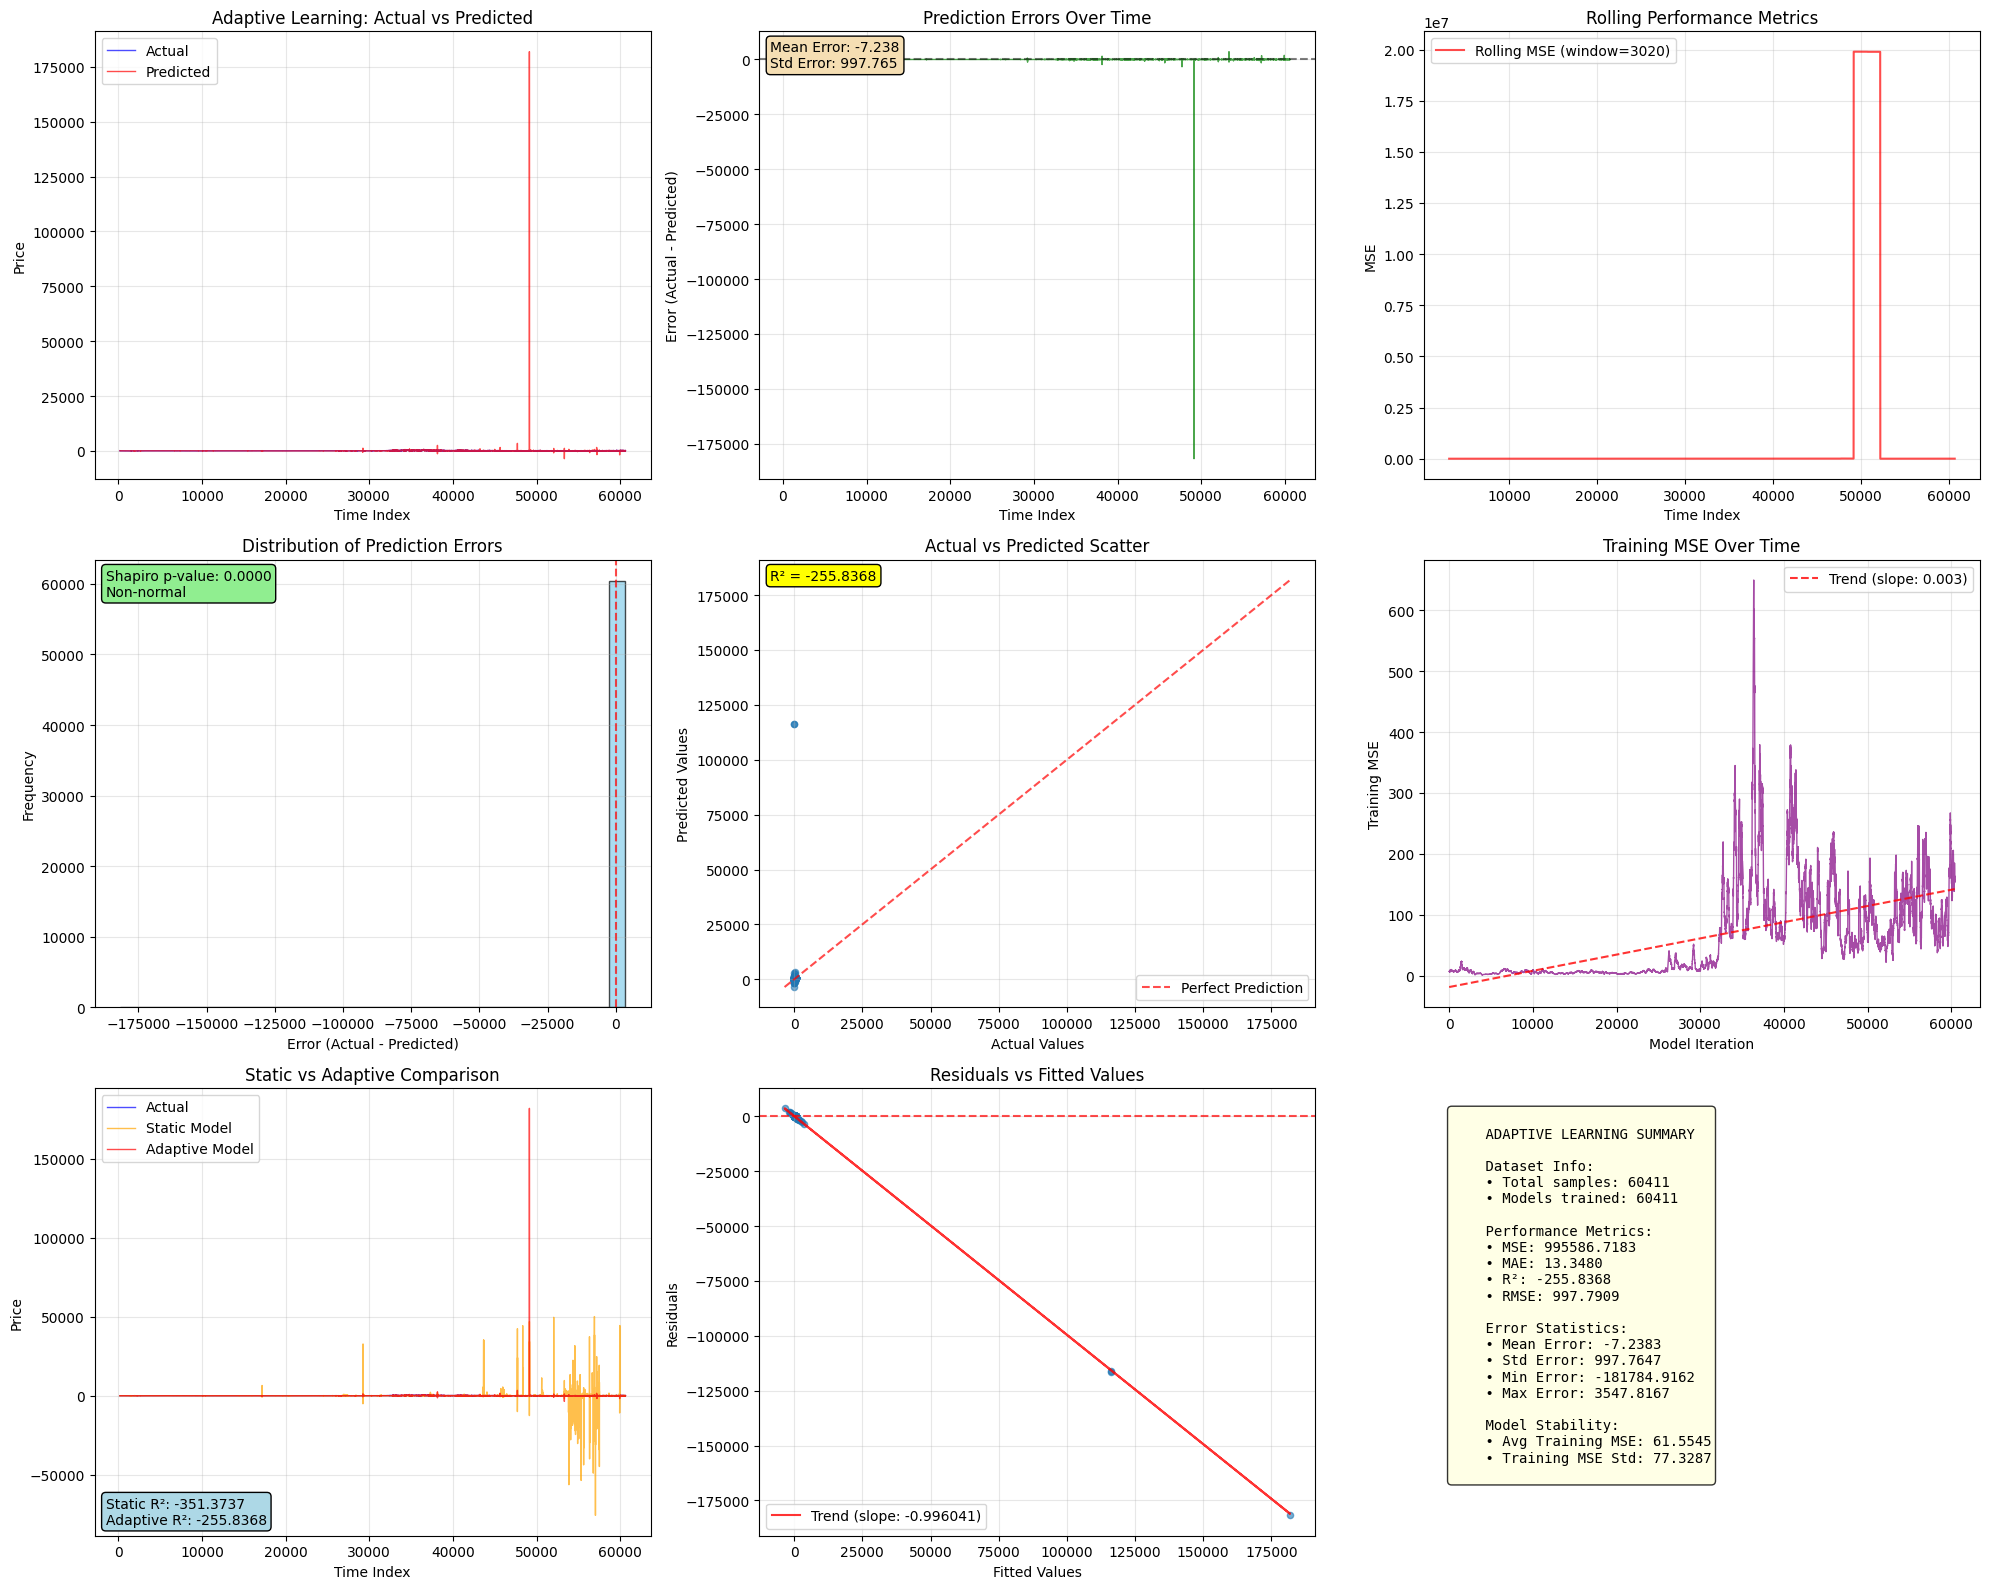


ADAPTIVE LEARNING VALIDATION ANALYSIS

1. PERFORMANCE METRICS:
   MSE: 995586.7183
   MAE: 13.3480
   R²:  -255.8368
   RMSE: 997.7909

2. ERROR ANALYSIS:
   Mean Error: -7.2383 (should be close to 0)
   Error Std:  997.7647
   Error Range: [-181784.92, 3547.82]

3. MODEL STABILITY:
   Models Trained: 60411
   Avg Training MSE: 61.5545
   Training MSE Variation: 77.3287

4. VALIDATION CHECKS:
   Error Trend: -0.000436 (should be close to 0)
   Residual Pattern: Good
   ✅ No significant systematic bias detected
   ⚠️  WARNING: R² is negative - model performs worse than mean prediction


In [46]:
plot_adaptive_learning_results(results, train_subset_df, lag_price_window, 
                              static_comparison=True, save_plots=True)

In [47]:
import numpy as np
from scipy import stats

def remove_outliers_from_results(results, method='iqr', threshold=3):
    """
    Remove outliers from prediction results and recalculate metrics.
    
    Parameters:
    -----------
    results : dict
        Results from adaptive_learning_pipeline
    method : str
        'iqr', 'zscore', or 'modified_zscore'
    threshold : float
        Threshold for outlier detection
    """
    predictions = results['predictions']
    actual_values = results['actual_values']
    errors = actual_values - predictions
    
    if method == 'iqr':
        Q1 = np.percentile(errors, 25)
        Q3 = np.percentile(errors, 75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        mask = (errors >= lower_bound) & (errors <= upper_bound)
        
    elif method == 'zscore':
        z_scores = np.abs(stats.zscore(errors))
        mask = z_scores < threshold
        
    elif method == 'modified_zscore':
        median = np.median(errors)
        mad = np.median(np.abs(errors - median))
        modified_z_scores = 0.6745 * (errors - median) / mad
        mask = np.abs(modified_z_scores) < threshold
    
    # Apply mask
    cleaned_predictions = predictions[mask]
    cleaned_actual = actual_values[mask]
    
    # Recalculate metrics
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
    
    cleaned_results = results.copy()
    cleaned_results['predictions'] = cleaned_predictions
    cleaned_results['actual_values'] = cleaned_actual
    cleaned_results['overall_mse'] = mean_squared_error(cleaned_actual, cleaned_predictions)
    cleaned_results['overall_mae'] = mean_absolute_error(cleaned_actual, cleaned_predictions)
    cleaned_results['overall_r2'] = r2_score(cleaned_actual, cleaned_predictions)
    cleaned_results['outliers_removed'] = len(predictions) - len(cleaned_predictions)
    
    print(f"Outliers removed: {cleaned_results['outliers_removed']} ({cleaned_results['outliers_removed']/len(predictions)*100:.1f}%)")
    print(f"Original MSE: {results['overall_mse']:.4f} -> Cleaned MSE: {cleaned_results['overall_mse']:.4f}")
    print(f"Original R²: {results['overall_r2']:.4f} -> Cleaned R²: {cleaned_results['overall_r2']:.4f}")
    
    return cleaned_results

# Apply outlier removal
cleaned_results = remove_outliers_from_results(results, method='iqr')

Outliers removed: 8984 (14.9%)
Original MSE: 995586.7183 -> Cleaned MSE: 15.0168
Original R²: -255.8368 -> Cleaned R²: 0.9951


Plot saved as adaptive_comprehensive_analysis.png


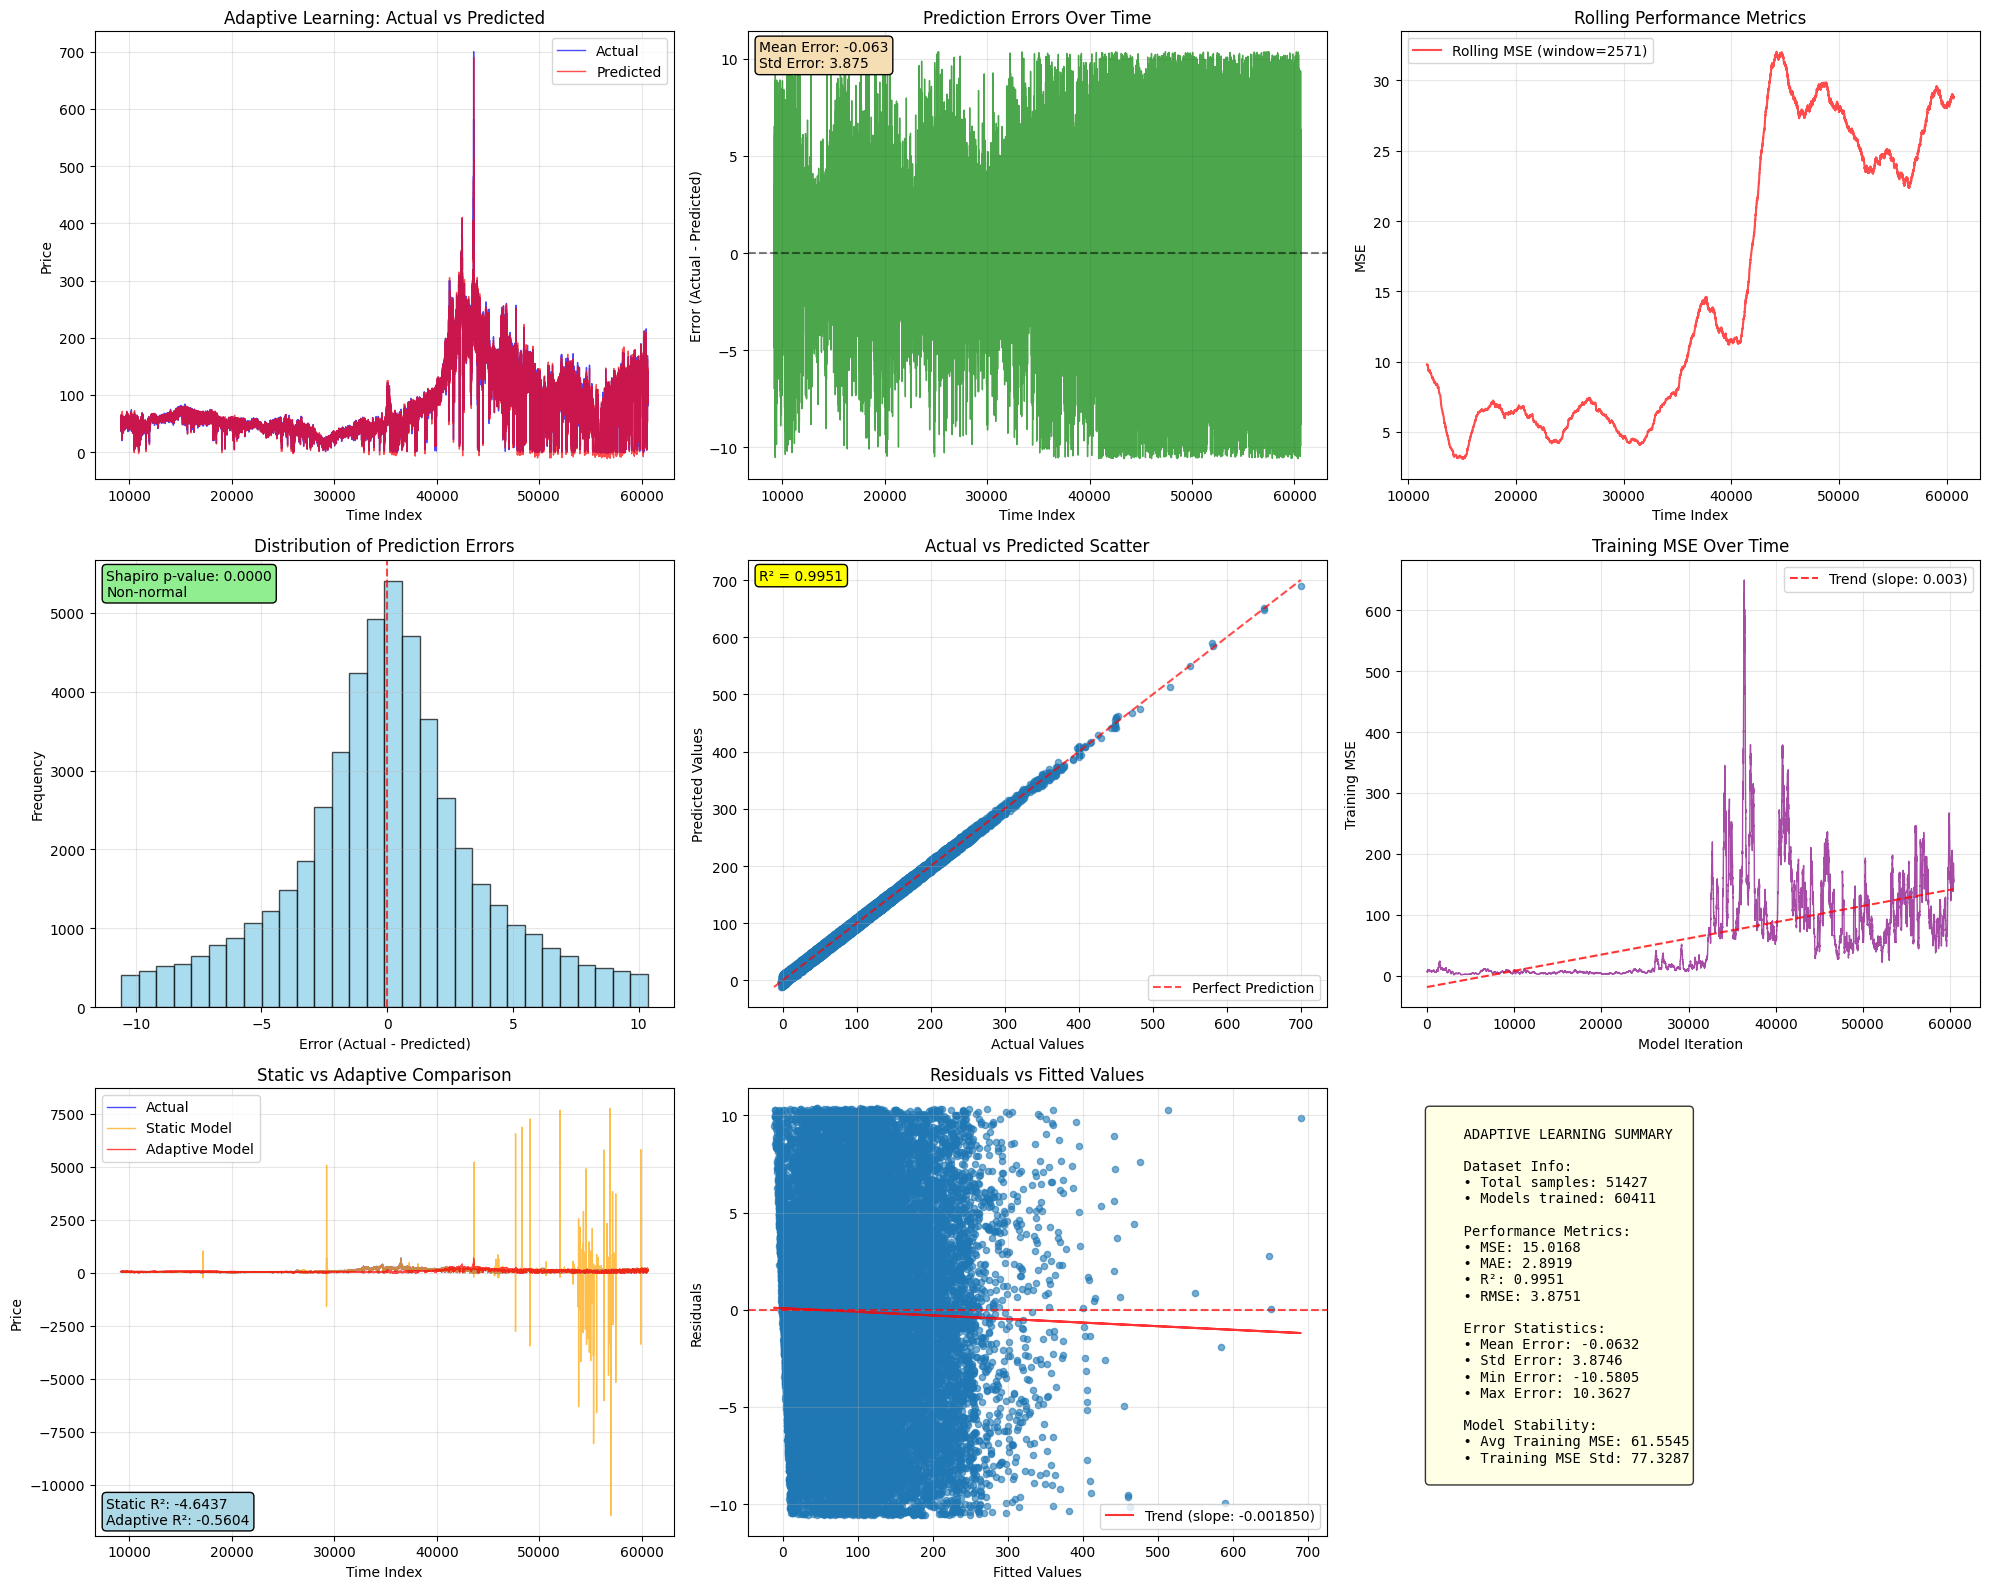


ADAPTIVE LEARNING VALIDATION ANALYSIS

1. PERFORMANCE METRICS:
   MSE: 15.0168
   MAE: 2.8919
   R²:  0.9951
   RMSE: 3.8751

2. ERROR ANALYSIS:
   Mean Error: -0.0632 (should be close to 0)
   Error Std:  3.8746
   Error Range: [-10.58, 10.36]

3. MODEL STABILITY:
   Models Trained: 60411
   Avg Training MSE: 61.5545
   Training MSE Variation: 77.3287

4. VALIDATION CHECKS:
   Error Trend: -0.000003 (should be close to 0)
   Residual Pattern: Good
   ✅ No significant systematic bias detected
   ✅ R² indicates reasonable model performance


In [48]:
plot_adaptive_learning_results(cleaned_results, train_subset_df, lag_price_window, 
                              static_comparison=True, save_plots=True)

In [41]:
def winsorize_predictions(results, percentile=0.05):
    """
    Cap extreme prediction errors at specified percentiles.
    """
    predictions = results['predictions'].copy()
    actual_values = results['actual_values'].copy()
    errors = actual_values - predictions
    
    # Calculate percentile bounds
    lower_bound = np.percentile(errors, percentile * 100)
    upper_bound = np.percentile(errors, (1 - percentile) * 100)
    
    # Cap the errors
    capped_errors = np.clip(errors, lower_bound, upper_bound)
    
    # Adjust predictions based on capped errors
    adjusted_predictions = actual_values - capped_errors
    
    # Recalculate metrics
    winsorized_results = results.copy()
    winsorized_results['predictions'] = adjusted_predictions
    winsorized_results['overall_mse'] = mean_squared_error(actual_values, adjusted_predictions)
    winsorized_results['overall_mae'] = mean_absolute_error(actual_values, adjusted_predictions)
    winsorized_results['overall_r2'] = r2_score(actual_values, adjusted_predictions)

    print(f"Winsorization applied at {percentile*100:.1f}%:")
    print(f"Original MSE: {results['overall_mse']:.4f} -> Winsorized MSE: {winsorized_results['overall_mse']:.4f}")
    print(f"Original R²: {results['overall_r2']:.4f} -> Winsorized R²: {winsorized_results['overall_r2']:.4f}")
    print(f"Lower bound: {lower_bound:.4f}, Upper bound: {upper_bound:.4f}")
    
    return winsorized_results

# Apply winsorization
winsorized_results = winsorize_predictions(results, percentile=0.02)

Winsorization applied at 2.0%:
Original MSE: 1428.4437 -> Winsorized MSE: 589.9537
Original R²: 0.6223 -> Winsorized R²: 0.8440
Lower bound: -69.4594, Upper bound: 58.8149


Plot saved as adaptive_comprehensive_analysis.png


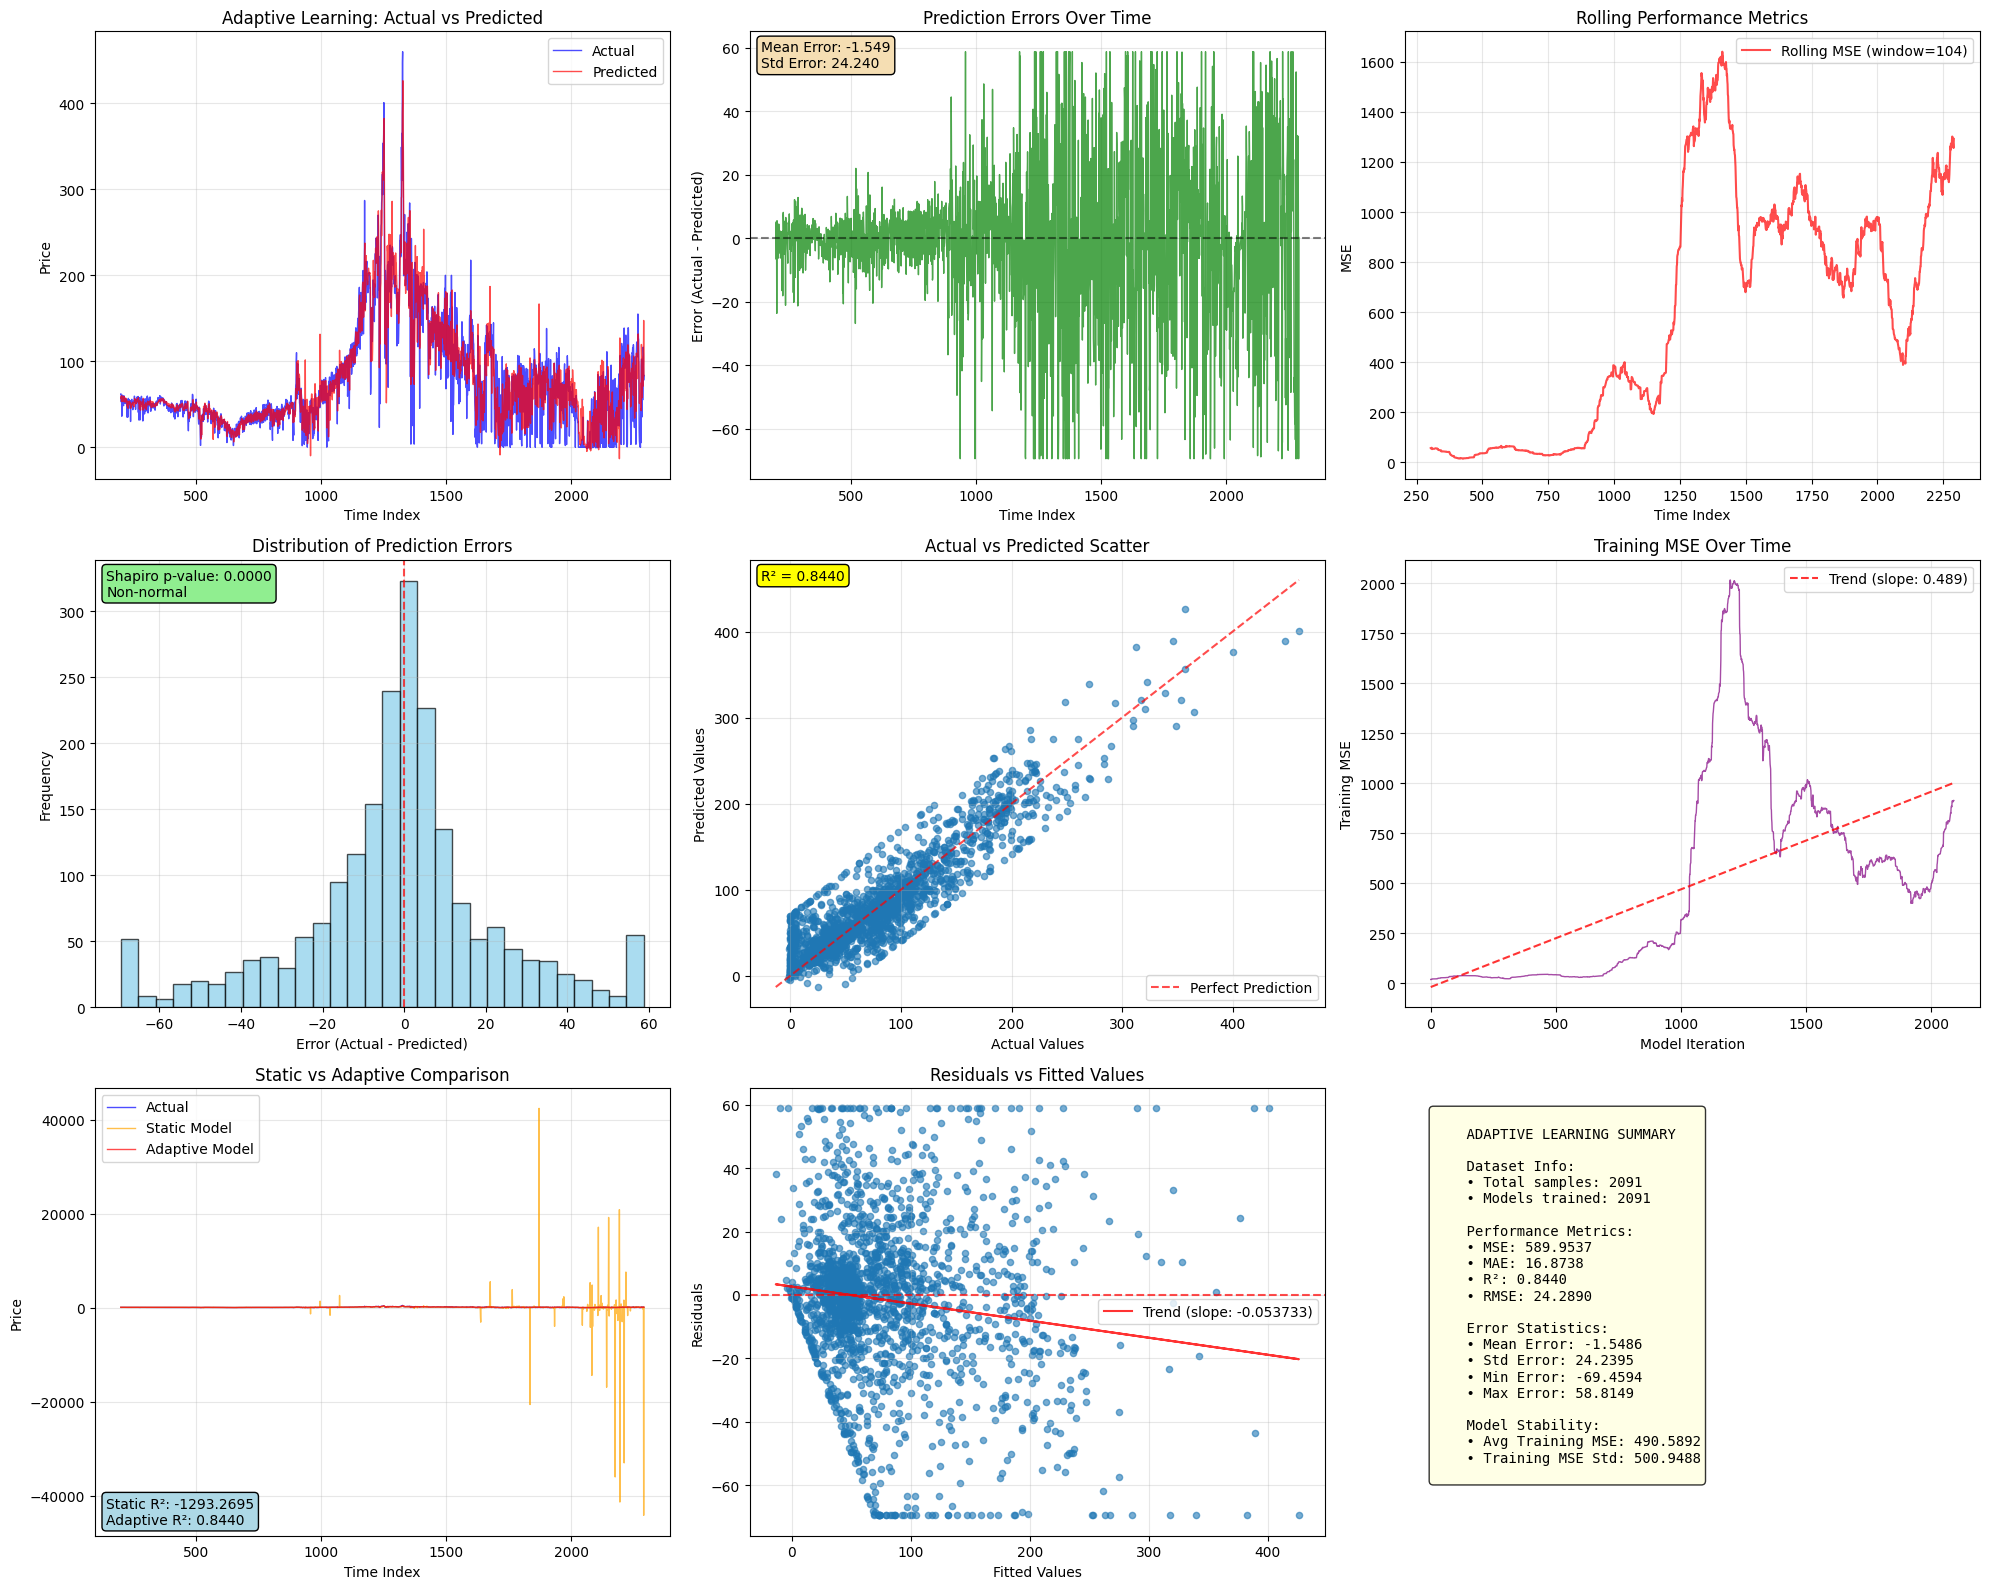


ADAPTIVE LEARNING VALIDATION ANALYSIS

1. PERFORMANCE METRICS:
   MSE: 589.9537
   MAE: 16.8738
   R²:  0.8440
   RMSE: 24.2890

2. ERROR ANALYSIS:
   Mean Error: -1.5486 (should be close to 0)
   Error Std:  24.2395
   Error Range: [-69.46, 58.81]

3. MODEL STABILITY:
   Models Trained: 2091
   Avg Training MSE: 490.5892
   Training MSE Variation: 500.9488

4. VALIDATION CHECKS:
   Error Trend: -0.000962 (should be close to 0)
   Residual Pattern: Good
   ✅ No significant systematic bias detected
   ✅ R² indicates reasonable model performance


In [42]:
plot_adaptive_learning_results(winsorized_results, train_subset_df, lag_price_window, 
                              static_comparison=True, save_plots=True)

In [36]:
# Modify your adaptive learning pipeline to use robust regression

from sklearn.linear_model import HuberRegressor
from sklearn.ensemble import RandomForestRegressor

def adaptive_learning_pipeline_robust(df, lag_price_window, training_window_size, 
                                    initial_train_size, step_size=1, alpha=0.1, 
                                    use_robust=True):
    """
    Robust version of adaptive learning pipeline.
    """
    # ...existing code...
    X_full, y_full = create_feature_matrix_with_features(df, lag_price_window)
    
    # Initialize storage for results
    predictions = []
    actual_values = []
    model_performances = []
    training_indices = []
    
    start_idx = initial_train_size
    
    for i in range(start_idx, len(X_full), step_size):
        train_end_idx = i
        train_start_idx = max(0, train_end_idx - training_window_size)
        
        X_train = X_full.iloc[train_start_idx:train_end_idx]
        y_train = y_full.iloc[train_start_idx:train_end_idx]
        
        if len(X_train) < 2:
            continue
        
        # Use robust regression instead of regular Lasso
        if use_robust:
            # Huber regression is robust to outliers
            model = HuberRegressor(epsilon=1.35, alpha=alpha, max_iter=2000)
        else:
            model = Lasso(alpha=alpha, max_iter=2000, tol=1e-4)
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            model.fit(X_train, y_train)
        
        # Make prediction for next point(s)
        pred_end_idx = min(i + step_size, len(X_full))
        X_pred = X_full.iloc[i:pred_end_idx]
        y_actual = y_full.iloc[i:pred_end_idx]
        
        y_pred = model.predict(X_pred)
        
        # Store results
        predictions.extend(y_pred)
        actual_values.extend(y_actual.values)
        training_indices.append((train_start_idx, train_end_idx))
        
        # Calculate performance on training window
        train_pred = model.predict(X_train)
        train_mse = mean_squared_error(y_train, train_pred)
        model_performances.append(train_mse)
    
    # ...rest of existing code...
    
    return results

# Run with robust regression
robust_results = adaptive_learning_pipeline_robust(
    df=train_subset_df,
    lag_price_window=lag_price_window,
    training_window_size=training_window_size,
    initial_train_size=initial_train_size,
    step_size=step_size,
    alpha=1,
    use_robust=True
)

KeyboardInterrupt: 

In [ ]:
plot_adaptive_learning_results(results, train_subset_df, lag_price_window, 
                              static_comparison=True, save_plots=True)